In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../")
import os

from povertymapping.rollout_grids import get_region_filtered_bingtile_grids, compute_raster_stats
from povertymapping.hdx import get_hdx_file
from povertymapping.iso3 import get_iso3_code
from povertymapping.geoboundaries import get_geoboundaries
import geowrangler.vector_zonal_stats as vzs

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import spearmanr

/home/jace/workspace/unicef-ai4d-poverty-mapping/env/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Set country-specific parameters

In [3]:
REGION = 'malaysia'
ADMIN_LVL = 'ADM2'
ZOOM_LEVEL = 14
GROUP_ZOOM_LEVEL = 8
country_code = get_iso3_code(REGION, code='alpha-2').lower()

## Read bounds

In [4]:
bounds_file = get_geoboundaries(region=REGION, adm='ADM1')
bounds_gdf = gpd.read_file(bounds_file)
bounds_gdf = bounds_gdf.sort_values('shapeName')

In [5]:
bounds_gdf.sort_values('shapeName')#.explore()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
1,Johor,MY-01,MYS-ADM1-3_0_0-B2,MYS,ADM1,"MULTIPOLYGON (((104.06240 2.21794, 104.06217 2..."
11,Kedah,MY-02,MYS-ADM1-3_0_0-B12,MYS,ADM1,"MULTIPOLYGON (((99.72140 6.20837, 99.72192 6.2..."
7,Kelantan,MY-03,MYS-ADM1-3_0_0-B8,MYS,ADM1,"MULTIPOLYGON (((101.33398 4.69564, 101.33467 4..."
2,Kuala Lumpur,MY-14,MYS-ADM1-3_0_0-B3,MYS,ADM1,"MULTIPOLYGON (((101.61508 3.15348, 101.61527 3..."
15,Labuan,MY-15,MYS-ADM1-3_0_0-B16,MYS,ADM1,"MULTIPOLYGON (((115.13150 5.21699, 115.13119 5..."
3,Malacca,MY-04,MYS-ADM1-3_0_0-B4,MYS,ADM1,"MULTIPOLYGON (((101.85494 2.41747, 101.86035 2..."
4,Negeri Sembilan,MY-05,MYS-ADM1-3_0_0-B5,MYS,ADM1,"MULTIPOLYGON (((101.71245 2.59533, 101.71259 2..."
10,Pahang,MY-06,MYS-ADM1-3_0_0-B11,MYS,ADM1,"MULTIPOLYGON (((101.33463 4.43296, 101.35839 4..."
14,Penang,MY-07,MYS-ADM1-3_0_0-B15,MYS,ADM1,"MULTIPOLYGON (((100.33822 5.57470, 100.33901 5..."
13,Perak,MY-08,MYS-ADM1-3_0_0-B14,MYS,ADM1,"MULTIPOLYGON (((100.63654 4.15716, 100.63688 4..."


In [6]:
#bounds_gdf[bounds_gdf.columns[:-1]].to_csv("./my-hes-2020.csv")

## Read reference data

In [7]:
data_df = pd.read_csv("./my-hes-2020.csv")
data_df = bounds_gdf.merge(data_df, left_on='shapeName', right_on='province_name', how='left')
data_df['rank'] = data_df['mean_total_expenditure_2016'].rank(ascending=False)
data_df

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry,province_name,mean_total_expenditure_2016,rank
0,Johor,MY-01,MYS-ADM1-3_0_0-B2,MYS,ADM1,"MULTIPOLYGON (((104.06240 2.21794, 104.06217 2...",Johor,4148.38,6.0
1,Kedah,MY-02,MYS-ADM1-3_0_0-B12,MYS,ADM1,"MULTIPOLYGON (((99.72140 6.20837, 99.72192 6.2...",Kedah,3061.06,14.0
2,Kelantan,MY-03,MYS-ADM1-3_0_0-B8,MYS,ADM1,"MULTIPOLYGON (((101.33398 4.69564, 101.33467 4...",Kelantan,2874.63,15.0
3,Kuala Lumpur,MY-14,MYS-ADM1-3_0_0-B3,MYS,ADM1,"MULTIPOLYGON (((101.61508 3.15348, 101.61527 3...",Kuala Lumpur,6214.21,2.0
4,Labuan,MY-15,MYS-ADM1-3_0_0-B16,MYS,ADM1,"MULTIPOLYGON (((115.13150 5.21699, 115.13119 5...",Labuan,4068.75,7.0
5,Malacca,MY-04,MYS-ADM1-3_0_0-B4,MYS,ADM1,"MULTIPOLYGON (((101.85494 2.41747, 101.86035 2...",Malacca,4373.80,4.0
6,Negeri Sembilan,MY-05,MYS-ADM1-3_0_0-B5,MYS,ADM1,"MULTIPOLYGON (((101.71245 2.59533, 101.71259 2...",Negeri Sembilan,3688.39,9.0
7,Pahang,MY-06,MYS-ADM1-3_0_0-B11,MYS,ADM1,"MULTIPOLYGON (((101.33463 4.43296, 101.35839 4...",Pahang,3316.16,10.0
8,Penang,MY-07,MYS-ADM1-3_0_0-B15,MYS,ADM1,"MULTIPOLYGON (((100.33822 5.57470, 100.33901 5...",Penang,4190.30,5.0
9,Perak,MY-08,MYS-ADM1-3_0_0-B14,MYS,ADM1,"MULTIPOLYGON (((100.63654 4.15716, 100.63688 4...",Perak,3233.28,11.0


## Read and process model output

In [8]:
out_gdf = gpd.read_file("../../../data/results/my/2023-02-21-my-rollout-output.geojson")
out_gdf.head()#explore(column='Predicted Relative Wealth Index')

,quadkey,shapeName,shapeISO,shapeID,shapeGroup,shapeType,pop_count,Predicted Relative Wealth Index,Predicted Wealth Category (quintile),geometry
0,13223202222021,Klang,None,MYS-ADM2-3_0_0-B57,MYS,ADM2,1948.905696,0.376365,B,"POLYGON ((101.27197 2.92110, 101.27197 2.94304..."
1,13223202222023,Klang,None,MYS-ADM2-3_0_0-B57,MYS,ADM2,5633.984424,0.405243,A,"POLYGON ((101.27197 2.89915, 101.27197 2.92110..."
2,13223202222201,Klang,None,MYS-ADM2-3_0_0-B57,MYS,ADM2,919.554096,0.323968,B,"POLYGON ((101.27197 2.87721, 101.27197 2.89915..."
3,13223202222010,Klang,None,MYS-ADM2-3_0_0-B57,MYS,ADM2,61.761096,0.344436,B,"POLYGON ((101.29395 2.96498, 101.29395 2.98693..."
4,13223202222012,Klang,None,MYS-ADM2-3_0_0-B57,MYS,ADM2,4659.531576,0.456739,A,"POLYGON ((101.29395 2.94304, 101.29395 2.96498..."


In [10]:
# get stats for provinces (ADM1)
out_gdf = vzs.create_zonal_stats(
    bounds_gdf,
    out_gdf,
    overlap_method="intersects",
    aggregations=[{"column":'Predicted Relative Wealth Index', "func": "mean", "output":"model_wealth_index_mean"}]
)
out_gdf['rank'] = out_gdf["model_wealth_index_mean"].rank(ascending=False)
out_gdf

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry,model_wealth_index_mean,rank
1,Johor,MY-01,MYS-ADM1-3_0_0-B2,MYS,ADM1,"MULTIPOLYGON (((104.06240 2.21794, 104.06217 2...",0.381330,9.0
11,Kedah,MY-02,MYS-ADM1-3_0_0-B12,MYS,ADM1,"MULTIPOLYGON (((99.72140 6.20837, 99.72192 6.2...",0.386537,8.0
7,Kelantan,MY-03,MYS-ADM1-3_0_0-B8,MYS,ADM1,"MULTIPOLYGON (((101.33398 4.69564, 101.33467 4...",0.319396,14.0
2,Kuala Lumpur,MY-14,MYS-ADM1-3_0_0-B3,MYS,ADM1,"MULTIPOLYGON (((101.61508 3.15348, 101.61527 3...",0.606565,1.0
15,Labuan,MY-15,MYS-ADM1-3_0_0-B16,MYS,ADM1,"MULTIPOLYGON (((115.13150 5.21699, 115.13119 5...",0.478113,4.0
3,Malacca,MY-04,MYS-ADM1-3_0_0-B4,MYS,ADM1,"MULTIPOLYGON (((101.85494 2.41747, 101.86035 2...",0.440914,6.0
4,Negeri Sembilan,MY-05,MYS-ADM1-3_0_0-B5,MYS,ADM1,"MULTIPOLYGON (((101.71245 2.59533, 101.71259 2...",0.379933,10.0
10,Pahang,MY-06,MYS-ADM1-3_0_0-B11,MYS,ADM1,"MULTIPOLYGON (((101.33463 4.43296, 101.35839 4...",0.323656,13.0
14,Penang,MY-07,MYS-ADM1-3_0_0-B15,MYS,ADM1,"MULTIPOLYGON (((100.33822 5.57470, 100.33901 5...",0.519304,3.0
13,Perak,MY-08,MYS-ADM1-3_0_0-B14,MYS,ADM1,"MULTIPOLYGON (((100.63654 4.15716, 100.63688 4...",0.364201,11.0


## Compare model output vs reference

In [11]:
compare_gdf = out_gdf[['shapeISO','shapeName','model_wealth_index_mean','rank', 'geometry']].merge(\
                    data_df[['shapeISO','shapeName','mean_total_expenditure_2016','rank']], on='shapeISO', how='outer', suffixes=['_reference', '_model']).dropna()
compare_gdf

,shapeISO,shapeName_reference,model_wealth_index_mean,rank_reference,geometry,shapeName_model,mean_total_expenditure_2016,rank_model
0,MY-01,Johor,0.381330,9.0,"MULTIPOLYGON (((104.06240 2.21794, 104.06217 2...",Johor,4148.38,6.0
1,MY-02,Kedah,0.386537,8.0,"MULTIPOLYGON (((99.72140 6.20837, 99.72192 6.2...",Kedah,3061.06,14.0
2,MY-03,Kelantan,0.319396,14.0,"MULTIPOLYGON (((101.33398 4.69564, 101.33467 4...",Kelantan,2874.63,15.0
3,MY-14,Kuala Lumpur,0.606565,1.0,"MULTIPOLYGON (((101.61508 3.15348, 101.61527 3...",Kuala Lumpur,6214.21,2.0
4,MY-15,Labuan,0.478113,4.0,"MULTIPOLYGON (((115.13150 5.21699, 115.13119 5...",Labuan,4068.75,7.0
5,MY-04,Malacca,0.440914,6.0,"MULTIPOLYGON (((101.85494 2.41747, 101.86035 2...",Malacca,4373.80,4.0
6,MY-05,Negeri Sembilan,0.379933,10.0,"MULTIPOLYGON (((101.71245 2.59533, 101.71259 2...",Negeri Sembilan,3688.39,9.0
7,MY-06,Pahang,0.323656,13.0,"MULTIPOLYGON (((101.33463 4.43296, 101.35839 4...",Pahang,3316.16,10.0
8,MY-07,Penang,0.519304,3.0,"MULTIPOLYGON (((100.33822 5.57470, 100.33901 5...",Penang,4190.30,5.0
9,MY-08,Perak,0.364201,11.0,"MULTIPOLYGON (((100.63654 4.15716, 100.63688 4...",Perak,3233.28,11.0


In [12]:
coef, p = spearmanr(compare_gdf['mean_total_expenditure_2016'], compare_gdf['model_wealth_index_mean'])
coef

0.7823529411764706

## Heatmap

In [13]:
def despine(ax):
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

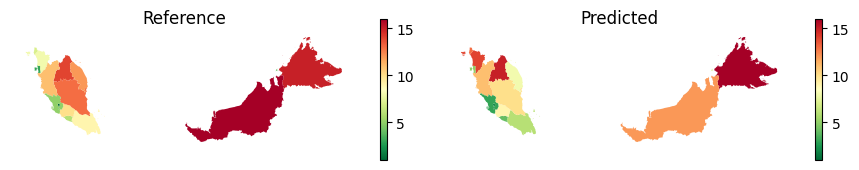

In [14]:
fig, axs = plt.subplots(1,2, figsize=(9,5))

compare_gdf.plot(
    column='rank_reference',
    ax=axs[0],
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds={"shrink": 0.3},
)
despine(axs[0])

compare_gdf.plot(
    column='rank_model',
    ax=axs[1],
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds={"shrink": 0.3},
)
despine(axs[1])
axs[0].set_title('Reference')
axs[1].set_title('Predicted')
# leg1 = axs[0].get_legend()
# leg1.set_title("Rank")
# leg2 = axs[1].get_legend()
# leg2.set_title("Rank")# 
#fig.suptitle('Wealth index rank')
fig.tight_layout()